In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision

In [2]:
from tqdm.notebook import tqdm

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='/kaggle/input/apparel-dataset', transform=transform)
val_dataset = datasets.ImageFolder(root='/kaggle/input/apparel-dataset', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

model = models.resnet50(progress = True)


In [4]:
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 37)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model = model.to(device)

Using device: cuda


In [6]:
num_epochs = 5

In [7]:
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Model Train
    model.train()
    train_loss = 0
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for inputs, labels in train_progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update progress bar [resnet50(progress = True)]
        train_progress_bar.set_postfix({'loss': loss.item()})
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Model validation
    model.eval()
    val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
    correct = 0
    total = 0
    for inputs, labels in val_progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
        
torch.save(model.state_dict(), '/kaggle/working/best_model.pth')

Epoch 1/5 [Training]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 1/5 [Validation]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 2/5 [Training]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 2/5 [Validation]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 3/5 [Training]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 3/5 [Validation]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 4/5 [Training]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 4/5 [Validation]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 5/5 [Training]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 5/5 [Validation]:   0%|          | 0/506 [00:00<?, ?it/s]

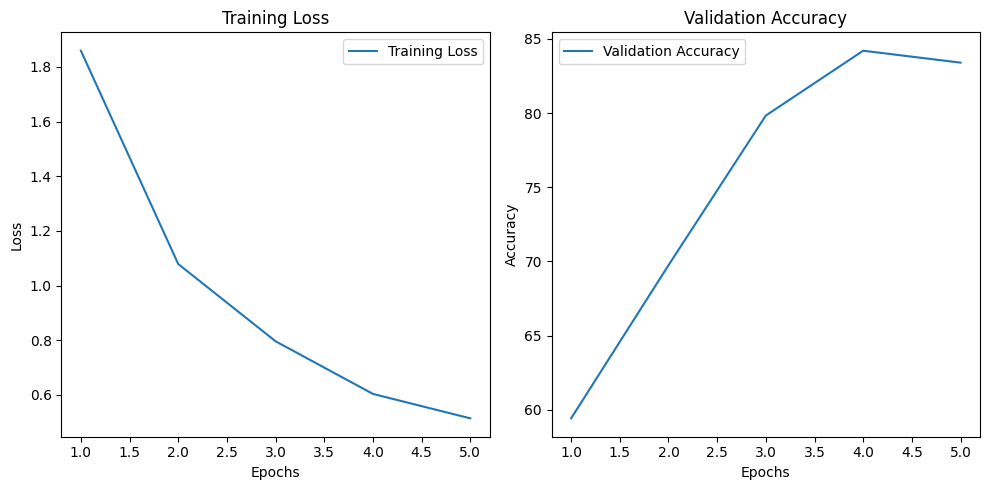

In [8]:
import matplotlib.pyplot as plt

#training loss visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

#validation visualize
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()